In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

color_pal = sns.color_palette()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dj-xgb-1/dow_data.csv


In [2]:
df = pd.read_csv("/kaggle/input/dj-xgb-1/dow_data.csv")
df.drop(columns='Adj Close', inplace = True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04,10430.690430,10604.969727,10430.690430,10583.959961,179780000
2010-01-05,10584.559570,10584.559570,10522.519531,10572.019531,188540000
2010-01-06,10564.719727,10594.990234,10546.549805,10573.679688,186040000
2010-01-07,10571.110352,10612.370117,10505.209961,10606.860352,217390000
2010-01-08,10606.400391,10619.400391,10554.330078,10618.190430,172710000
...,...,...,...,...,...
2023-12-22,37349.269531,37534.519531,37268.878906,37385.968750,252970000
2023-12-26,37405.898438,37617.988281,37371.828125,37545.328125,212420000
2023-12-27,37518.621094,37683.699219,37488.601562,37656.519531,245530000


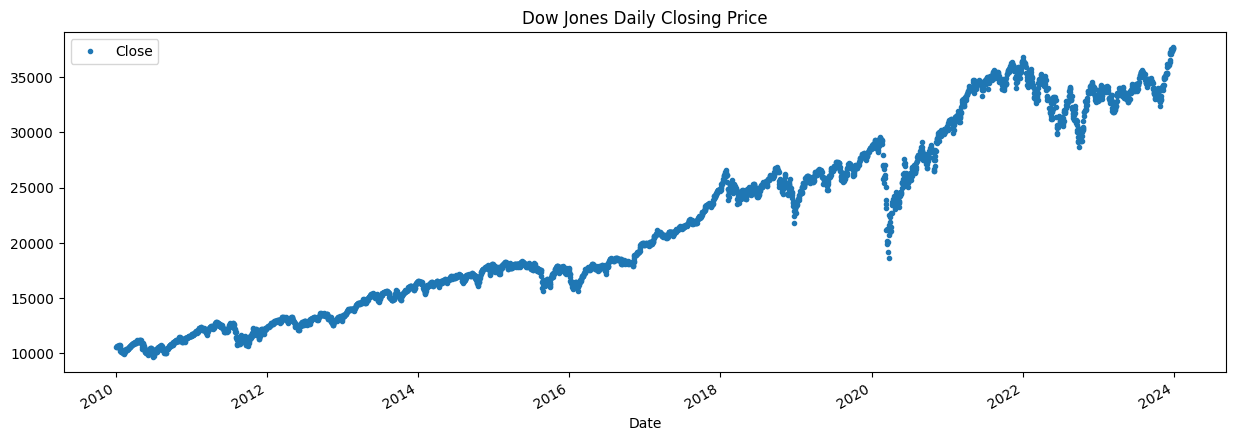

In [3]:
df.plot(y='Close', figsize=(15,5), color= color_pal[0],
        title='Dow Jones Daily Closing Price', use_index=True, style='.')
plt.show()

In [4]:
close_df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
close_df

,Close
Date,
2010-01-04,10583.959961
2010-01-05,10572.019531
2010-01-06,10573.679688
2010-01-07,10606.860352
2010-01-08,10618.190430
...,...
2023-12-22,37385.968750
2023-12-26,37545.328125
2023-12-27,37656.519531


In [5]:
def create_lag_features(df,col,lags):
    """
    Create time series features based on time series index.
    """
    #df = df.sort_index()
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    for lag in lags:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    df = df.sort_index(ascending= False)
    return df

lags = [x for x in range(1,61)]
aug_df = create_lag_features(close_df,'Close', lags)
aug_df = aug_df.loc[aug_df.index > '03-30-2010']
aug_df

,Close,quarter,year,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5,Close_lag_6,Close_lag_7,...,Close_lag_51,Close_lag_52,Close_lag_53,Close_lag_54,Close_lag_55,Close_lag_56,Close_lag_57,Close_lag_58,Close_lag_59,Close_lag_60
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-29,37689.539062,4,2023,37710.101562,37656.519531,37545.328125,37385.968750,37404.351562,37082.000000,37557.921875,...,33997.648438,33984.539062,33670.289062,33631.140625,33804.871094,33739.300781,33604.648438,33407.578125,33119.570312,33129.550781
2023-12-28,37710.101562,4,2023,37656.519531,37545.328125,37385.968750,37404.351562,37082.000000,37557.921875,37306.019531,...,33984.539062,33670.289062,33631.140625,33804.871094,33739.300781,33604.648438,33407.578125,33119.570312,33129.550781,33002.378906
2023-12-27,37656.519531,4,2023,37545.328125,37385.968750,37404.351562,37082.000000,37557.921875,37306.019531,37305.160156,...,33670.289062,33631.140625,33804.871094,33739.300781,33604.648438,33407.578125,33119.570312,33129.550781,33002.378906,33433.351562
2023-12-26,37545.328125,4,2023,37385.968750,37404.351562,37082.000000,37557.921875,37306.019531,37305.160156,37248.351562,...,33631.140625,33804.871094,33739.300781,33604.648438,33407.578125,33119.570312,33129.550781,33002.378906,33433.351562,33507.500000
2023-12-22,37385.968750,4,2023,37404.351562,37082.000000,37557.921875,37306.019531,37305.160156,37248.351562,37090.238281,...,33804.871094,33739.300781,33604.648438,33407.578125,33119.570312,33129.550781,33002.378906,33433.351562,33507.500000,33666.339844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-04-07,10897.519531,2,2010,10969.990234,10973.549805,10927.070312,10856.629883,10907.419922,10895.860352,10850.360352,...,10172.980469,10389.879883,10603.150391,10725.429688,10609.650391,10710.549805,10680.769531,10627.259766,10663.990234,10618.190430
2010-04-06,10969.990234,2,2010,10973.549805,10927.070312,10856.629883,10907.419922,10895.860352,10850.360352,10841.209961,...,10389.879883,10603.150391,10725.429688,10609.650391,10710.549805,10680.769531,10627.259766,10663.990234,10618.190430,10606.860352
2010-04-05,10973.549805,2,2010,10927.070312,10856.629883,10907.419922,10895.860352,10850.360352,10841.209961,10836.150391,...,10603.150391,10725.429688,10609.650391,10710.549805,10680.769531,10627.259766,10663.990234,10618.190430,10606.860352,10573.679688


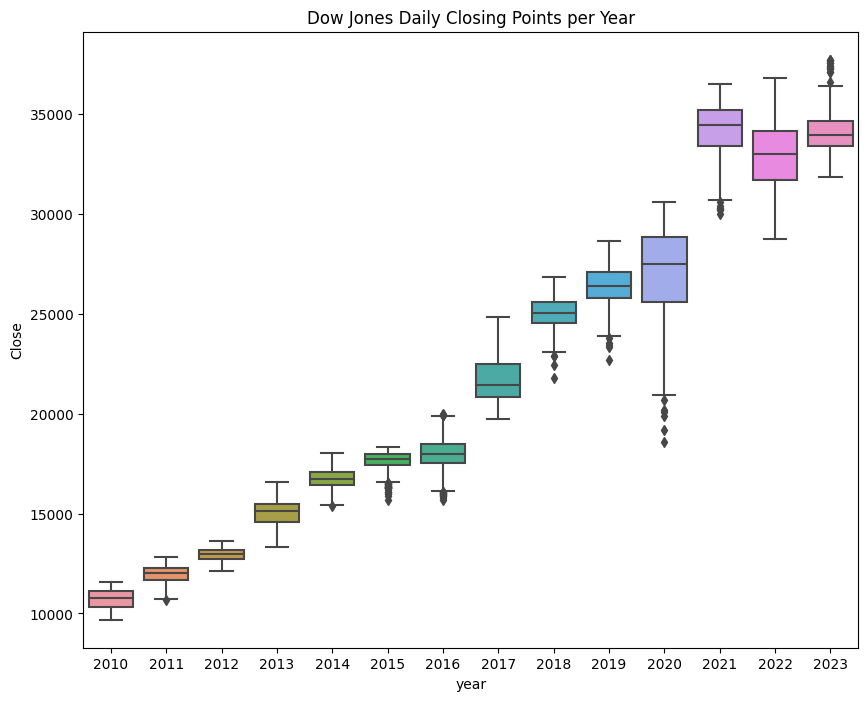

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='year', y='Close')
ax.set_title('Dow Jones Daily Closing Points per Year')
plt.show()

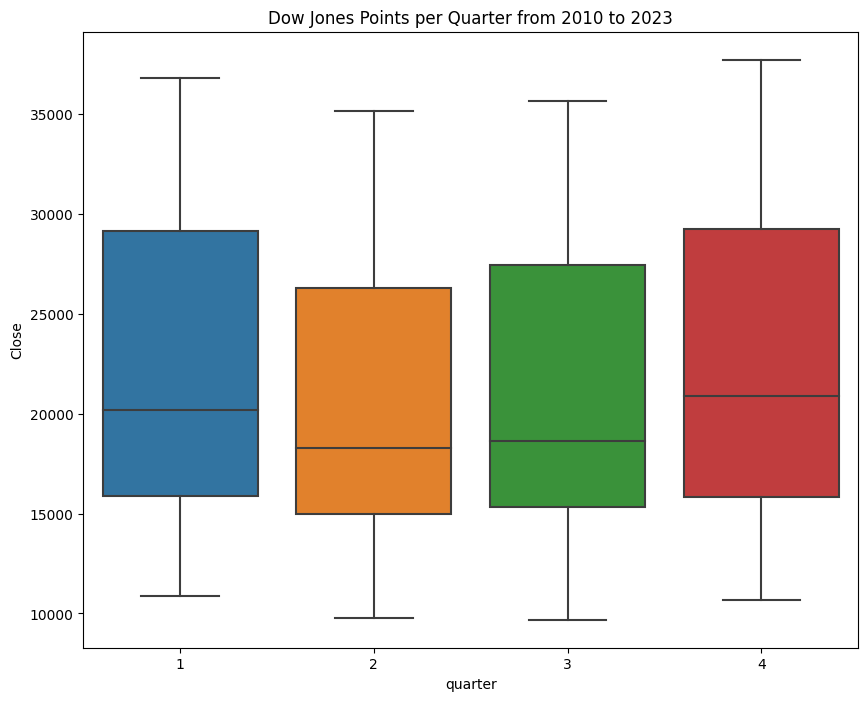

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=aug_df, x='quarter', y='Close')
ax.set_title('Dow Jones Points per Quarter from 2010 to 2023')
plt.show()

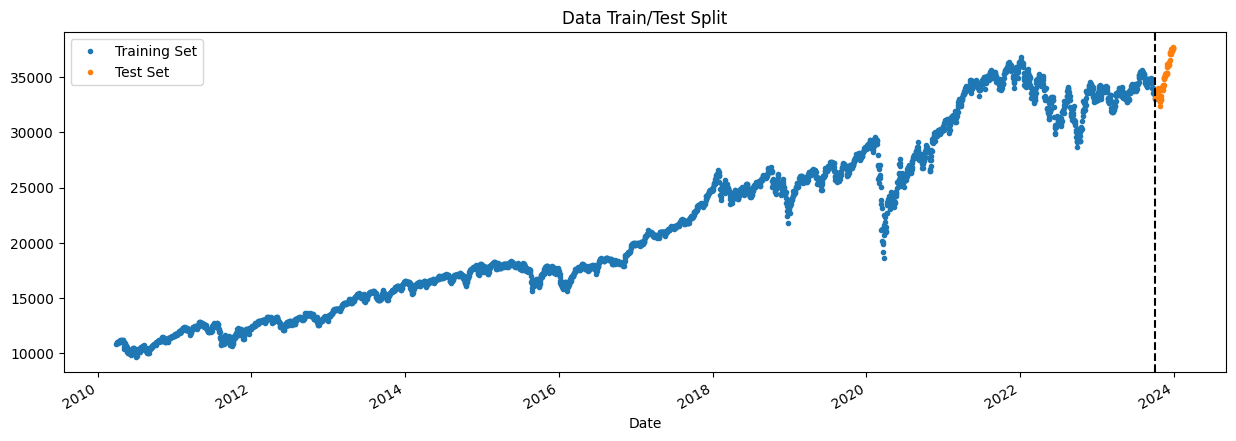

In [8]:
train = aug_df.loc[aug_df.index < '10-05-2023']
test = aug_df.loc[aug_df.index >= '10-05-2023']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, y='Close', label='Training Set', title= 'Data Train/Test Split', style='.')
test.plot(ax=ax, y='Close', label='Test Set', style='.')
ax.axvline('10-05-2023', color='black', ls='--')
plt.show()

train_features = []
for lag in range(1, 61):
        train_features.append(f'Close_lag_{lag}')

X_train = train[train_features]
Y_train = train['Close']

X_test = test[train_features]
Y_test = test['Close']

In [10]:
#Normalize Data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.fit_transform(X_test)

Y_train_scaled = target_scaler.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
Y_test_scaled = target_scaler.fit_transform(Y_test.values.reshape(-1, 1)).flatten()

test.loc[:,'Price_scaled'] = Y_test_scaled

In [12]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=450,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
model.fit(X_train_scaled, Y_train_scaled, eval_set=[(X_train_scaled, Y_train_scaled), (X_test_scaled, Y_test_scaled)], verbose=50)

test.loc[:,'prediction_scaled'] = model.predict(X_test_scaled)
test.loc[:,'prediction'] = target_scaler.inverse_transform(test['prediction_scaled'].values.reshape(-1, 1)).flatten()

[0]	validation_0-rmse:0.29196	validation_1-rmse:0.29629
[50]	validation_0-rmse:0.17833	validation_1-rmse:0.18946
[100]	validation_0-rmse:0.10919	validation_1-rmse:0.12635
[150]	validation_0-rmse:0.06716	validation_1-rmse:0.08970
[200]	validation_0-rmse:0.04171	validation_1-rmse:0.06939
[250]	validation_0-rmse:0.02648	validation_1-rmse:0.05961
[300]	validation_0-rmse:0.01761	validation_1-rmse:0.05549
[350]	validation_0-rmse:0.01271	validation_1-rmse:0.05369
[396]	validation_0-rmse:0.01036	validation_1-rmse:0.05329


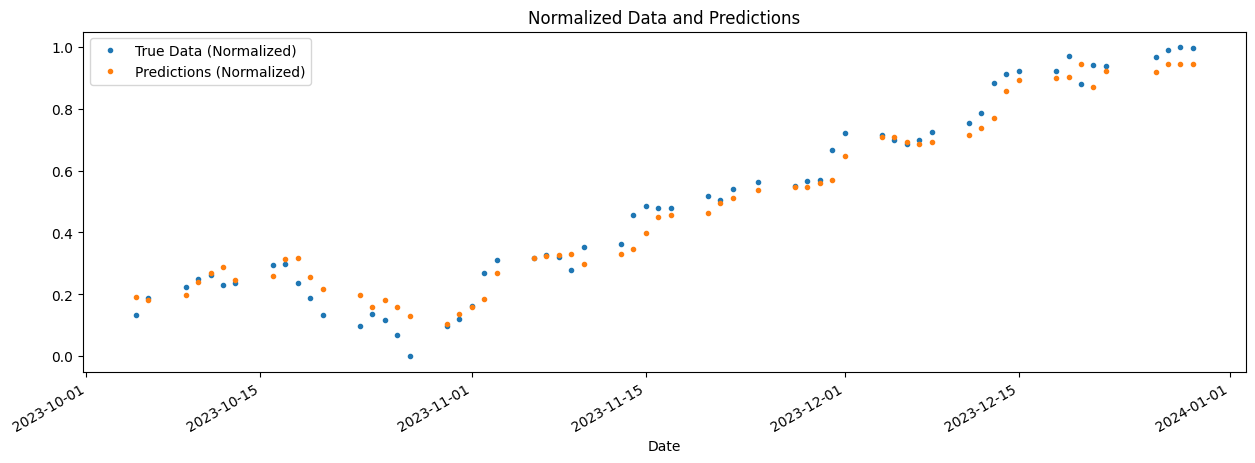

In [13]:
# Plot normalized data and predictions
fig, ax = plt.subplots(figsize=(15, 5))

# Plot true data
test['Price_scaled'].plot(ax=ax, style='.', label='True Data (Normalized)')

# Plot predictions
test['prediction_scaled'].plot(ax=ax, style='.', label='Predictions (Normalized)')

plt.legend()
plt.title('Normalized Data and Predictions')
plt.show()

In [14]:
np.sqrt(mean_squared_error(test['Price_scaled'], test['prediction_scaled']))

0.053263802484481274

In [17]:
#Not Normalized
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=850,
                       early_stopping_rounds=10,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       random_state=59)
reg.fit(X_train, Y_train, eval_set=[(X_train, Y_train), (X_test, Y_test)], verbose=50)

[0]	validation_0-rmse:22820.29945	validation_1-rmse:34714.21304
[50]	validation_0-rmse:13837.99400	validation_1-rmse:21387.89964
[100]	validation_0-rmse:8393.86554	validation_1-rmse:13301.45825
[150]	validation_0-rmse:5094.87028	validation_1-rmse:8338.60081
[200]	validation_0-rmse:3096.50593	validation_1-rmse:5324.09452
[250]	validation_0-rmse:1888.15745	validation_1-rmse:3478.22020
[300]	validation_0-rmse:1160.65278	validation_1-rmse:2333.92701
[350]	validation_0-rmse:727.51061	validation_1-rmse:1634.00352
[400]	validation_0-rmse:476.67073	validation_1-rmse:1211.14462
[450]	validation_0-rmse:338.91422	validation_1-rmse:970.16172
[500]	validation_0-rmse:268.96549	validation_1-rmse:837.24522
[550]	validation_0-rmse:236.62908	validation_1-rmse:760.86904
[600]	validation_0-rmse:222.19726	validation_1-rmse:720.17926
[650]	validation_0-rmse:214.92003	validation_1-rmse:700.48205
[700]	validation_0-rmse:210.89840	validation_1-rmse:686.66093
[750]	validation_0-rmse:208.19949	validation_1-rmse:

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=850, n_jobs=None,
             num_parallel_tree=None, random_state=59, ...)

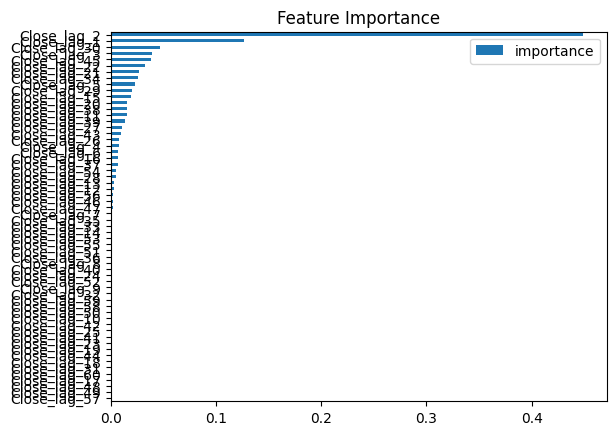

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

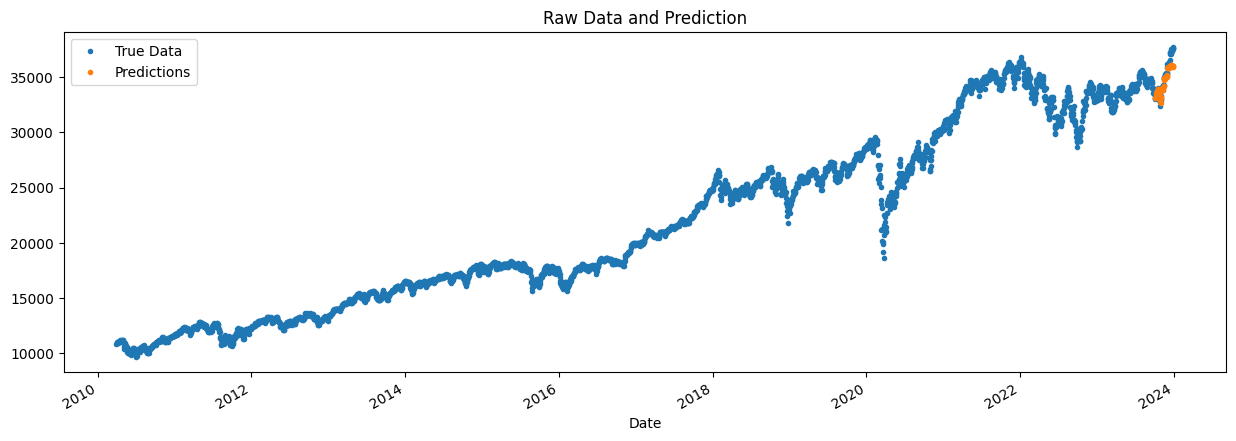

In [21]:
test.loc[:,'prediction'] = reg.predict(X_test)
aug_df = aug_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = aug_df[['Close']].plot(figsize=(15, 5), style='.')
aug_df['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [22]:
test['prediction'].head(40)

Date
2023-12-29    35955.789062
2023-12-28    36043.000000
2023-12-27    36036.714844
2023-12-26    36026.617188
2023-12-22    36099.632812
2023-12-21    36017.000000
2023-12-20    36116.429688
2023-12-19    36108.503906
2023-12-18    36029.101562
2023-12-15    36056.667969
2023-12-14    36058.707031
2023-12-13    36055.941406
2023-12-12    35984.437500
2023-12-11    35976.066406
2023-12-08    35837.664062
2023-12-07    35843.117188
2023-12-06    35840.585938
2023-12-05    35812.726562
2023-12-04    35950.546875
2023-12-01    35863.941406
2023-11-30    35179.902344
2023-11-29    35123.277344
2023-11-28    35064.476562
2023-11-27    35139.042969
2023-11-24    35091.062500
2023-11-22    34916.910156
2023-11-21    34947.253906
2023-11-20    34888.425781
2023-11-17    34840.367188
2023-11-16    34900.105469
2023-11-15    34755.414062
2023-11-14    34204.335938
2023-11-13    34168.859375
2023-11-10    33809.296875
2023-11-09    34048.824219
2023-11-08    34165.062500
2023-11-07    34048.558

In [24]:
np.sqrt(mean_squared_error(test['Close'], test['prediction']))

678.5533010976995

In [26]:
avg_price = test['Close'].mean()
avg_price

35020.277669270836